# Data Browser

View sample images, labels, and summary statistics from datasets 

In [1]:
from dataloaders import make_dataset
from dataloaders import custom_transforms as tr
from dataloaders.utils import decode_segmap
from torch.utils.data import DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import math

from types import SimpleNamespace

### Set these variables as desired to load different datasets.

In [15]:
dataset_name = 'cityscapes'

#All figures will be saved with the following prefix
figure_prefix = "figures/cityscapes_"

# Dataset directory root
root = '../datasets/cityscapes/'

# Default configuration file
cfg_file = '../configs/cityscapes_rgbd.yaml'

# Extra configurations
cfg_list = ['DATASET.CITYSCAPES.GT_MODE', 'gtFine',
            'DATASET.CITYSCAPES.TRAIN_SET', 'train']

# Load configuration
from deeplab3.config.defaults import get_cfg_defaults
cfg = get_cfg_defaults()
cfg.merge_from_file(cfg_file)
cfg.merge_from_list(['DATASET.ROOT', root])
cfg.merge_from_list(cfg_list)

Loading RGB-D and segmentation
-------

The depth and RGB are saved as seperate jpg files. Each is loaded seperately, then they are concatenated into a 4-channel image with the depth channel takeing the place of an alpha channel. All four channels are normalized and a random crop, horizontal flip, and gaussian blur are applied for image augmentation. The same transformation are applied to the segmentation mask.

Let's start by looking at a batch of 4 images and segmentation masks.

In [16]:
def display_grid(images, labels):
    
    n = len(labels)
    plt.figure(figsize=(16, 8))
    
#     m = math.ceil(n/4)
    for ii in range(n):
        if images[ii] is not None:
            plt.subplot(1, n, ii+1)
            plt.imshow(images[ii])
            plt.title(labels[ii])
            plt.axis('off')

In [17]:
def display_labels(colors, names):
    # for i = range(10)
    fig = plt.figure(figsize=(2, 5))
    ax = plt.subplot(1,2,1)
    plt.imshow(colors[:, :10, :].transpose((1,0,2)))
    plt.yticks(range(10), names[:10])
    ax.get_xaxis().set_visible(False)

    ax = plt.subplot(1,2,2)
    plt.imshow(colors[:, 10:, :].transpose((1,0,2)))
    plt.yticks(range(9), names[10:])
    ax.yaxis.tick_right()
    ax.get_xaxis().set_visible(False)

    plt.tight_layout()
    fig.savefig(figure_prefix + 'segmentation_legend.eps', format='eps', dpi=300)
    

Using RGB-D input
Found 500 val images
['../datasets/cityscapes/leftImg8bit/val/lindau/lindau_000041_000019_leftImg8bit.png']
['../datasets/cityscapes/leftImg8bit/val/lindau/lindau_000018_000019_leftImg8bit.png']
['../datasets/cityscapes/leftImg8bit/val/lindau/lindau_000057_000019_leftImg8bit.png']
['../datasets/cityscapes/leftImg8bit/val/lindau/lindau_000028_000019_leftImg8bit.png']
['../datasets/cityscapes/leftImg8bit/val/lindau/lindau_000007_000019_leftImg8bit.png']


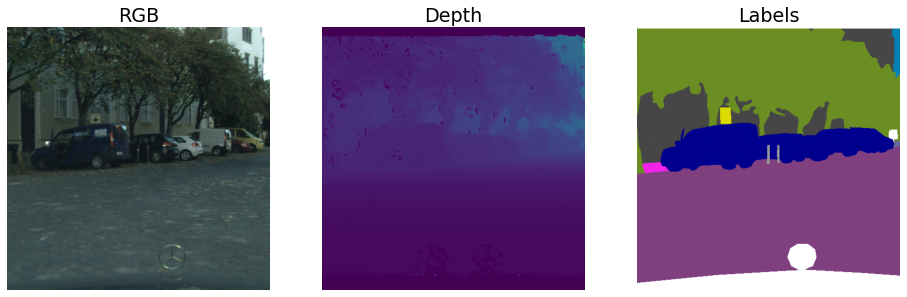

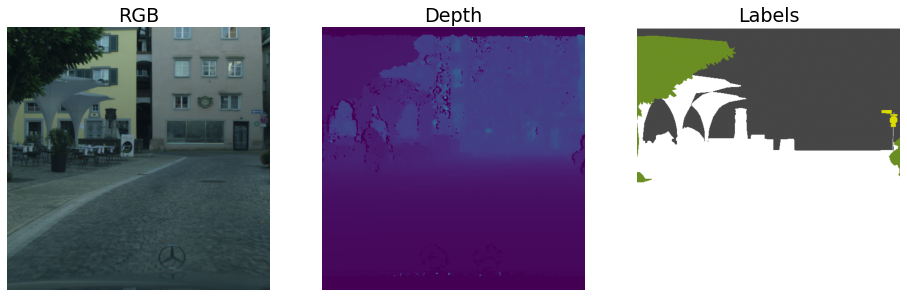

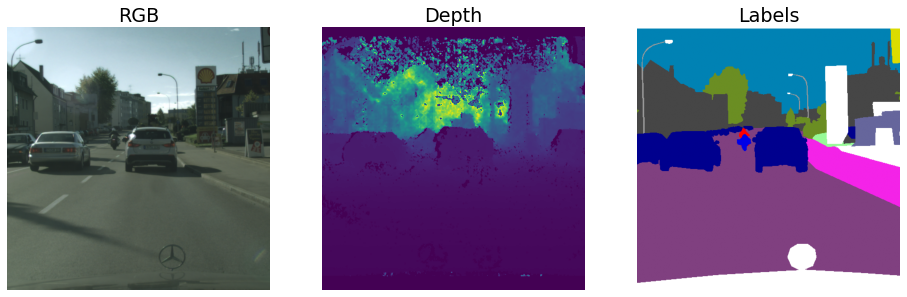

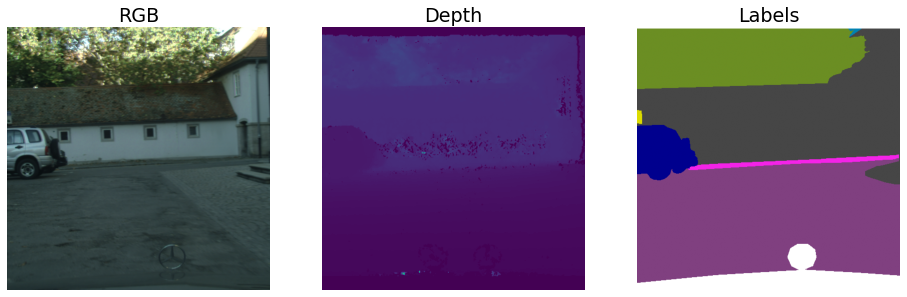

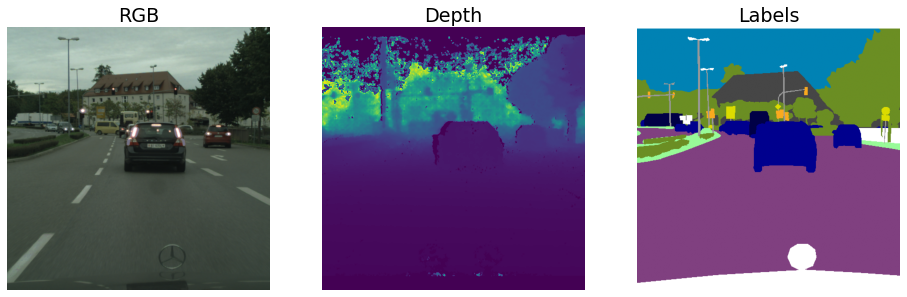

In [18]:
#Same as main method of dataloaders.datasets.coco
val = make_dataset(cfg, split='val')

dataloader = DataLoader(val, batch_size=1, shuffle=False, num_workers=0)

for ii, sample in enumerate(dataloader):
    for jj in range(sample["image"].size()[0]):
        img_tmp = val.loader.invert_normalization(sample['image'].squeeze())
        gt = sample['label'].numpy()
        tmp = np.array(gt[jj]).astype(np.uint8)
        segmap = decode_segmap(tmp, dataset=dataset_name)
        
        imgs = [img_tmp[:,:,:3], img_tmp[:,:,3:].squeeze(), segmap]
        labels = ['RGB', 'Depth', 'Labels']
        display_grid(imgs, labels)

    print(sample["id"])
    if ii == 4:
        break

plt.show(block=True)

There is a fixed semantic segmentation labels color palette for each dataset. Use dataloaders.get_label_colors to retrieve the color palette.

<ipython-input-17-980f2cbf258b>:15: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  plt.tight_layout()


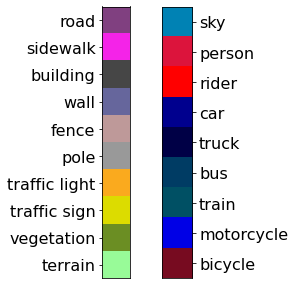

In [19]:
from dataloaders import get_label_colors

font = {'size'   : 16}

matplotlib.rc('font', **font)

#Class colors for reference
names = [x.replace('_', ' ') for x in val.loader.class_names]
colors = np.expand_dims(get_label_colors(cfg), 0)

display_labels(colors,names)

## Pixel Intensity Histograms

In [20]:
from dataloaders.utils import sample_distribution

In [21]:
def plot_distribution(a_list, bins, percent=False):
    ax = plt.figure()
    bin_middle = np.array([(bins[x] + bins[x + 1]) / 2.0 for x in range(len(bins) - 1)])
    for a in a_list:
        n = np.histogram(a, bins=bins)[0]
        if percent:
            n = n / np.sum(n)
        # y = scipy.stats.norm.pdf(b, 0, 1)
        plt.plot(bin_middle[np.nonzero(n)], n[np.nonzero(n)])

    return ax

In [22]:
dist_train = sample_distribution(make_dataset(cfg, split='train'), n=100)

0it [00:00, ?it/s]

Using RGB-D input
Found 2975 train images


100it [00:25,  3.97it/s]


### RGB

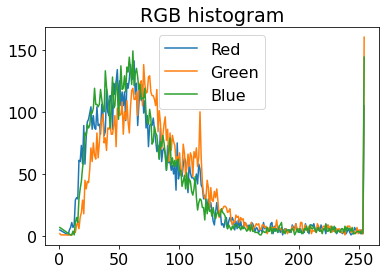

In [23]:
bins = np.linspace(0,255, num=256)
plot_distribution([dist_train['samples'][:, 0],
                  dist_train['samples'][:, 1],
                  dist_train['samples'][:, 2]], bins)
plt.title("RGB histogram")
plt.legend(["Red", "Green", "Blue"])
plt.show()

### Measured Depth

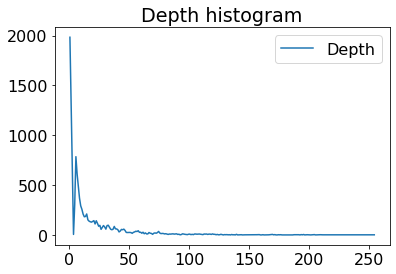

In [24]:
bins = np.linspace(0,255, num=256)
plot_distribution([dist_train['samples'][:, 3:]], bins)
plt.title("Depth histogram")
plt.show()

In [25]:
print("{} mean: {} \n \t std: {}".format(dataset_name, 
                                         dist_train['mean'], 
                                         dist_train['std']))

cityscapes mean: [74.0844     83.9165     73.2111     24.63031283] 
 	 std: [46.92241977 47.70711821 47.03121237 40.59357681]


### Synthetic Depth

0it [00:00, ?it/s]

Using RGB-D input
Found 19997 train_extra images


100it [00:29,  3.36it/s]


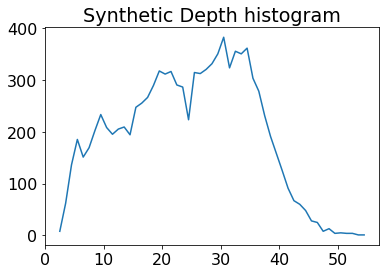

cityscapes mean: [80.9435     91.3112     79.8092     24.31409725] 
 	 std: [49.42922524 50.22857707 50.27002084 10.35442543]


In [26]:
# Extra configurations
cfg_list = ['DATASET.CITYSCAPES.DEPTH_DIR', 'VNL_Monocular']

# Load configuration
from deeplab3.config.defaults import get_cfg_defaults
cfg = get_cfg_defaults()
cfg.merge_from_file(cfg_file)
cfg.merge_from_list(['DATASET.ROOT', root])
cfg.merge_from_list(cfg_list)

dist_synth = sample_distribution(make_dataset(cfg, split='train'), n=100)

bins = np.linspace(0,255, num=256)
plot_distribution([dist_synth['samples'][:, 3:]], bins)
plt.title("Synthetic Depth histogram")
plt.show()

print("{} mean: {} \n \t std: {}".format(dataset_name, 
                                         dist_synth['mean'], 
                                         dist_synth['std']))

### Completed Depth

0it [00:00, ?it/s]

Using RGB-D input
Found 19997 train_extra images


100it [00:27,  3.61it/s]


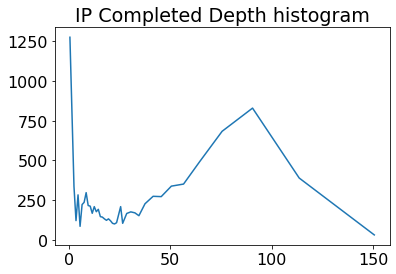

cityscapes mean: [80.7895     90.9411     79.2701     34.80296571] 
 	 std: [48.58618517 49.4275837  49.26246589 33.37131418]


In [27]:
# Extra configurations
cfg_list = ['DATASET.CITYSCAPES.DEPTH_DIR', 'completed_depth']

# Load configuration
from deeplab3.config.defaults import get_cfg_defaults
cfg = get_cfg_defaults()
cfg.merge_from_file(cfg_file)
cfg.merge_from_list(['DATASET.ROOT', root])
cfg.merge_from_list(cfg_list)

dist_lidar = sample_distribution(make_dataset(cfg, split='train'), n=100)

bins = np.linspace(0,255, num=256)
plot_distribution([dist_lidar['samples'][:, 3:]], bins)
plt.title("IP Completed Depth histogram")
plt.show()

print("{} mean: {} \n \t std: {}".format(dataset_name, 
                                         dist_lidar['mean'], 
                                         dist_lidar['std']))

### HHA

0it [00:00, ?it/s]

Using RGB HHA input
Found 19997 train_extra images


100it [00:28,  3.51it/s]


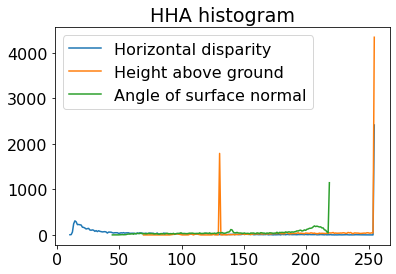

cityscapes mean: [ 79.0845  89.4851  78.335  107.0576 211.9489 166.7644] 
 	 std: [47.92185681 48.76746024 48.40315666 95.36250354 50.17486511 47.86351108]


In [30]:
# Extra configurations
cfg_list = ['DATASET.CITYSCAPES.DEPTH_DIR', 'HHA',
           'DATASET.MODE', 'RGB_HHA']

# Load configuration
from deeplab3.config.defaults import get_cfg_defaults
cfg = get_cfg_defaults()
cfg.merge_from_file(cfg_file)
cfg.merge_from_list(['DATASET.ROOT', root])
cfg.merge_from_list(cfg_list)

dist_hha = sample_distribution(make_dataset(cfg, split='train'), n=100)

bins = np.linspace(0,255, num=256)
plot_distribution([dist_hha['samples'][:, 3], dist_hha['samples'][:, 4], dist_hha['samples'][:, 5]], bins)
plt.title("HHA histogram")
plt.legend(["Horizontal disparity", "Height above ground", "Angle of surface normal"])
plt.show()

print("{} mean: {} \n \t std: {}".format(dataset_name, 
                                         dist_hha['mean'], 
                                         dist_hha['std']))